In [309]:
import networkx as nx 
import matplotlib.pyplot as plt 
import random
from qiskit import *
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np


import import_ipynb
import karger_algorithm  


Variation of the Karger algorithm implemented in minimal cut of Quantum circuits

In [310]:

def karger_min_cut_circuit(G, pos, bool_plot, qubit_top_nodes, exclude_nodes):
    G = G.copy()  # Hacemos una copia para no modificar el original
    
    # Conectar los qubits superiores entre sí
    for i in range(len(qubit_top_nodes) - 1):
        if f'q_top_{qubit_top_nodes[i]}' in exclude_nodes and f'q_top_{qubit_top_nodes[i + 1]}' in exclude_nodes:
            G.add_edge(f'q_top_{qubit_top_nodes[i]}', f'q_top_{qubit_top_nodes[i + 1]}', weight=1)
        else:
            G.add_edge(f'q_top_{qubit_top_nodes[i]}', f'q_top_{qubit_top_nodes[i + 1]}', weight=10)
    iteration = 1
    
    if exclude_nodes is None:
        exclude_nodes = []
    exclude_nodes = [f'q_top_{node}' for node in exclude_nodes]
        
    # Mientras queden más de dos nodos en el grafo
    while len(G.nodes) > 2:
        
        # Filtrar aristas que no involucren los nodos a excluir
        edges = [(u, v) for u, v in G.edges if u not in exclude_nodes and v not in exclude_nodes]
        

        # Contraemos la arista (fusionamos u y v)
        
        if len(G.nodes) == 3:
                u = random.choice(exclude_nodes)
                v = next(node for node in G.nodes if node not in exclude_nodes)
                
        else:
            u, v = random.choice(edges)
        
        G = karger_algorithm.merge_nodes(G, u, v)
        
        if bool_plot:
            # Graficar el grafo después de la contracción
            edge_labels = nx.get_edge_attributes(G, 'weight')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
            node_colors = ['lightgreen' if node.startswith('q_top_') or node.startswith('q_') else 'skyblue' for node in G.nodes()]
            nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_color=node_colors, edge_color="black", node_size=1500, font_size=9, font_weight="bold", width=2)
            plt.title(f"Iteración {iteration}: Grafo después de contraer {u} y {v}")
            plt.show()
        
        iteration += 1


    # Encontramos los dos nodos restantes y calculamos el peso total de las aristas entre ellos
    remaining_nodes = list(G.nodes)
    u, v = remaining_nodes
    
    cut_weight = G[u][v].get('weight', 1)
    return cut_weight - 1

In [311]:
#Create my circuit
n_qubits = 10
n_partition = 4

qc = QuantumCircuit(n_qubits)
qc.h(0)
qc.cx(6,7)
qc.cx(7, 8)
for i in range(9):
    qc.cx(i, i+1)

qc.cx(3, 4)
qc.cx(4, 5)

function `circuit_to_graph` takes a Quantum Circuit and returns a graph where each blue node represents a gate and each green edge represents a qubit.

In [312]:

def circuit_to_graph(qc):
    n_qubits = qc.num_qubits

    # Convertir a grafo
    G = nx.Graph()
    
    # Agregar nodos para cada qubit con etiquetas
    qubit_top_nodes = []
    for qubit in range(n_qubits):
        qubit_top_node = f'q_top_{qubit}'
        G.add_node(f'q_{qubit}', label=f'q_{qubit}')
        G.add_node(qubit_top_node, label=f'q_{qubit}')
        qubit_top_nodes.append(qubit)  
            
    # Agregar nodos y aristas para las compuertas CNOT con identificadores únicos
    cnot_counter = 0
    previous_cnot_nodes = {}
    for gate, qubits, clbits in qc.data:
        if gate.name == 'cx': 
            qubit_indices = [qc.qubits.index(qubit) for qubit in qubits]
            cnot_id = f'CNOT-{cnot_counter}'
            G.add_node(cnot_id, label=f'CNOT-{cnot_counter}', index=cnot_counter)
                
            for qubit_index in qubit_indices:
                if qubit_index in previous_cnot_nodes:
                    G.add_edge(cnot_id, previous_cnot_nodes[qubit_index])
                else:
                    G.add_edge(cnot_id, f'q_{qubit_index}')
                previous_cnot_nodes[qubit_index] = cnot_id
            
            cnot_counter += 1

    # Conectar los últimos nodos CNOT a los qubits superiores
    for qubit_index in range(n_qubits):
        if qubit_index in previous_cnot_nodes:
            G.add_edge(previous_cnot_nodes[qubit_index], f'q_top_{qubit_index}')

    # Fijar la posición de los nodos
    pos = {}
    
    # Posiciones de los qubits en una fila en la parte inferior
    for i in range(n_qubits):
        pos[f'q_{i}'] = (i, 0)
        pos[f'q_top_{i}'] = (i, cnot_counter + 2)  # Posiciones de los qubits superiores

    # Posiciones de las compuertas CNOT en filas superiores
    cnot_counter = 0
    for gate, qubits, clbits in qc.data:
        if gate.name == 'cx':
            qubit_indices = [qc.qubits.index(qubit) for qubit in qubits]
            cnot_id = f'CNOT-{cnot_counter}'
            pos[cnot_id] = (sum(qubit_indices) / len(qubit_indices), cnot_counter + 1)
            cnot_counter += 1

    return G, pos, qubit_top_nodes

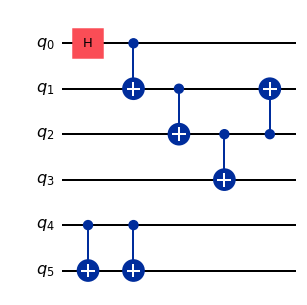

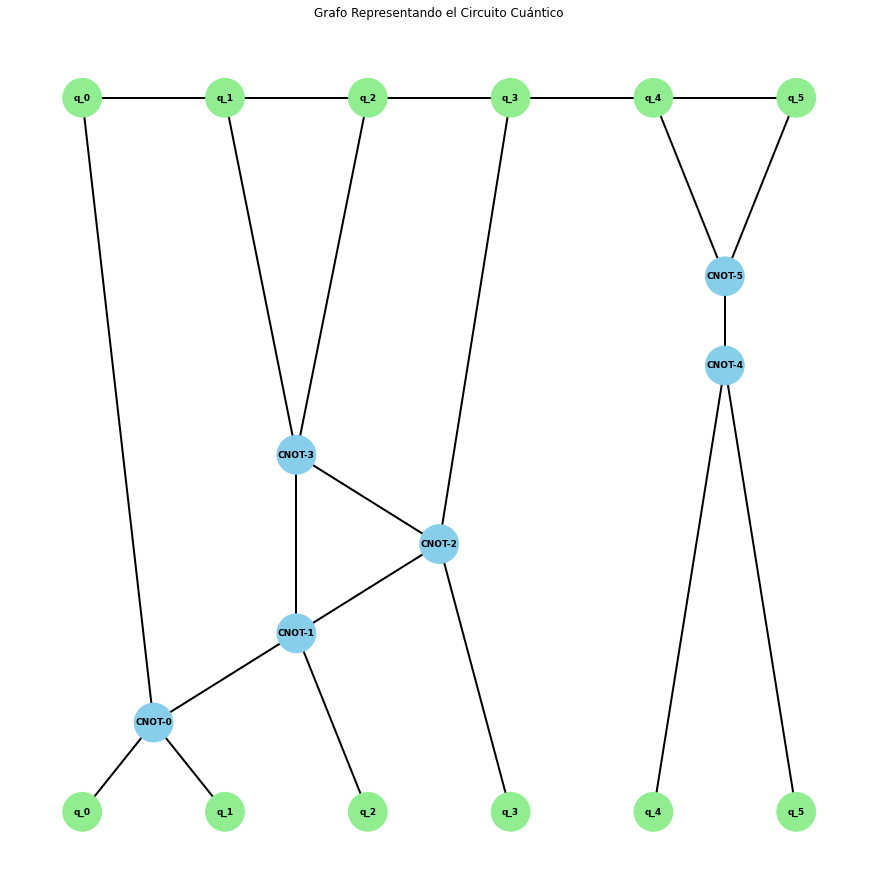

El corte mínimo encontrado por el algoritmo de Karger es: 1


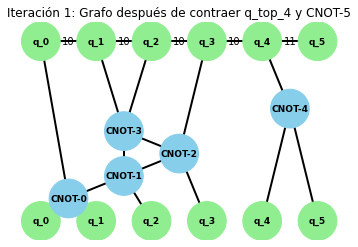

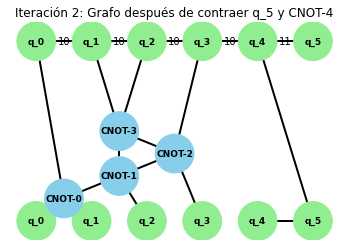

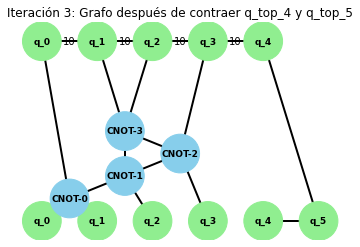

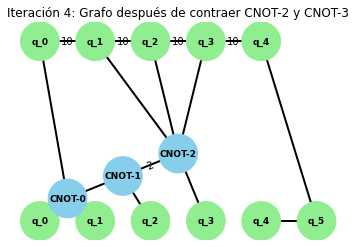

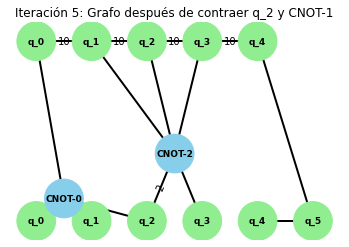

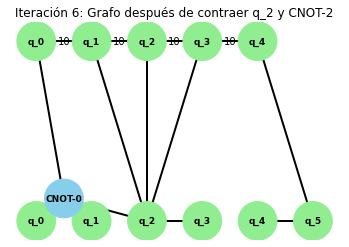

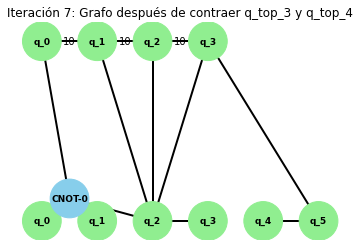

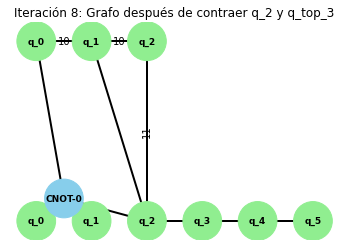

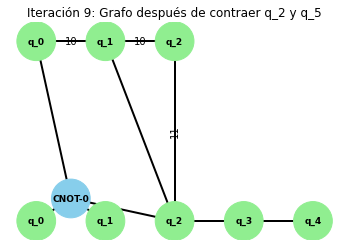

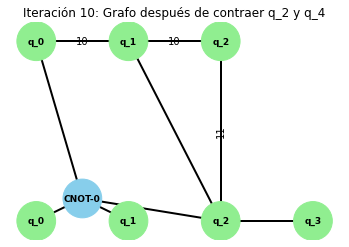

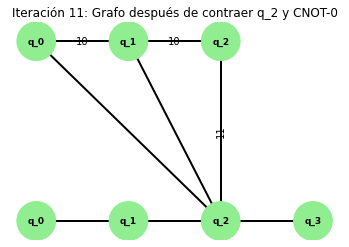

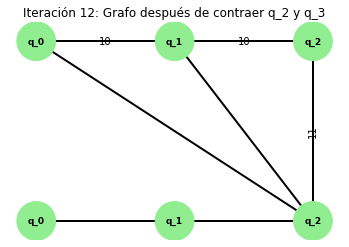

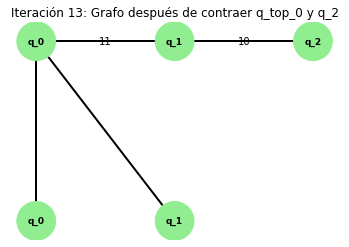

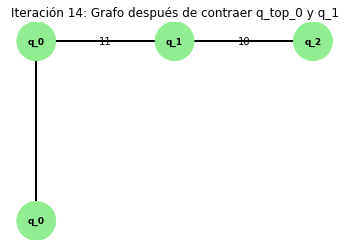

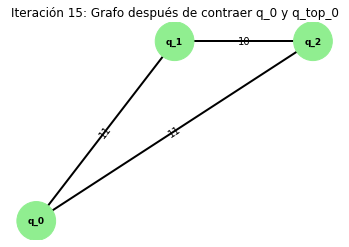

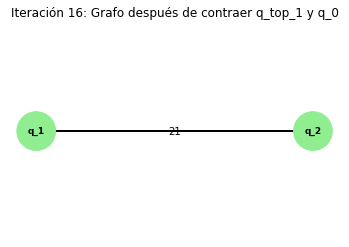

El corte minimo pasando por los quitbs [1, 2] es: 20


In [315]:

G, pos, qubit_top_nodes = circuit_to_graph(qc)

# Dibujar el grafo
plt.figure(figsize=(12, 12))
node_colors = ['skyblue' if 'CNOT' in node else 'lightgreen' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_color=node_colors, edge_color="black", node_size=1500, font_size=9, font_weight="bold", width=2)
plt.title("Grafo Representando el Circuito Cuántico")


# Mostrar el circuito cuántico y el grafo
display(qc.draw(output='mpl'))
plt.show()

# Ejecutamos el algoritmo de Karger varias veces para aumentar la precisión
trials = 1
min_cut = float('inf')
    
for _ in range(trials):
    cut = karger_algorithm.karger_min_cut_weighted(G, False)
    min_cut = min(min_cut, cut)
    
print("El corte mínimo encontrado por el algoritmo de Karger es:", min_cut)

# Excluir nodos 2 y 3
exclude_nodes = [1, 2]

min_cut = float('inf')
    
for _ in range(trials):
    cut = karger_min_cut_circuit(G, pos, True, qubit_top_nodes, exclude_nodes)
    min_cut = min(min_cut, cut)
    
print(f"El corte minimo pasando por los quitbs {exclude_nodes} es: {min_cut}")

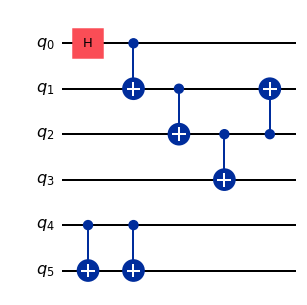

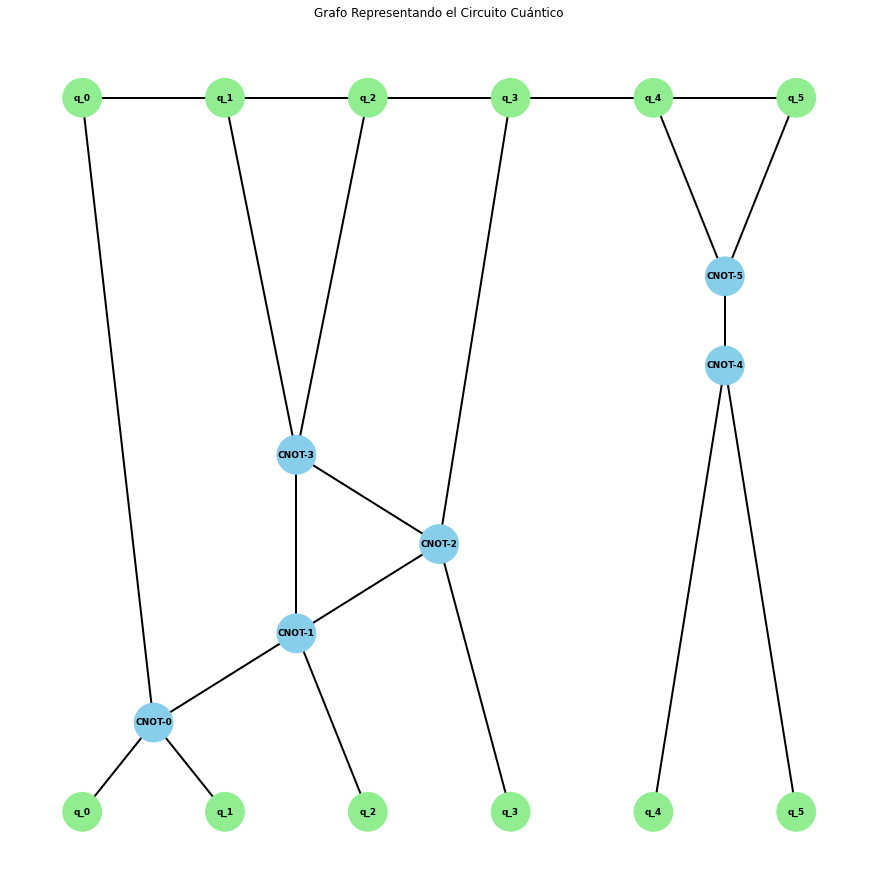

El corte mínimo encontrado por el algoritmo de Karger es: 3


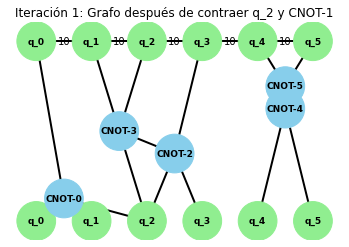

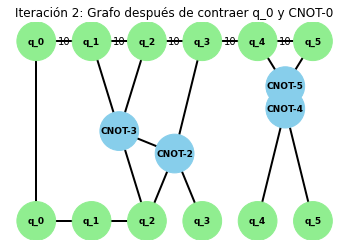

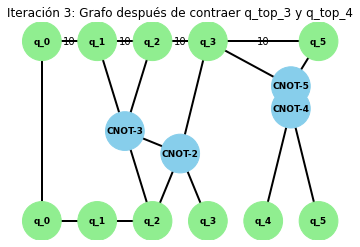

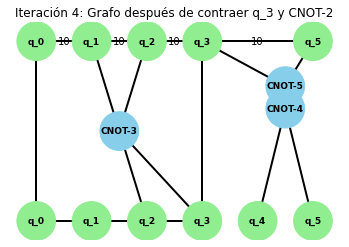

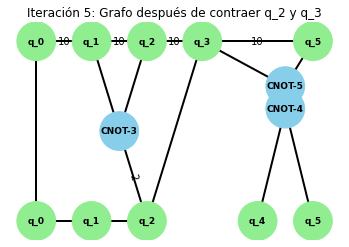

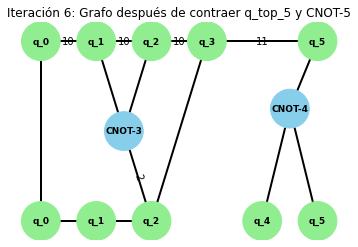

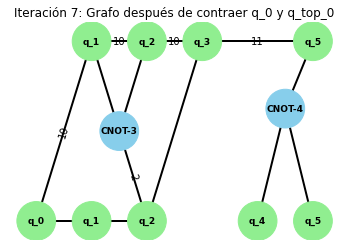

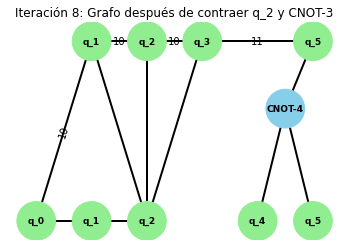

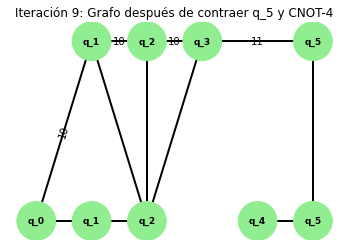

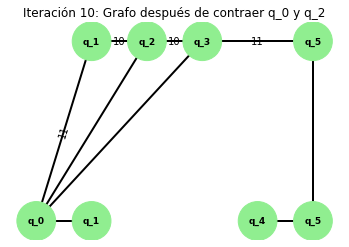

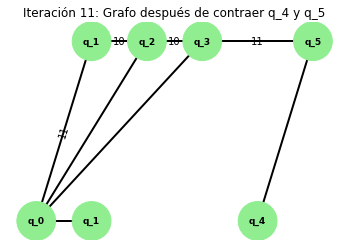

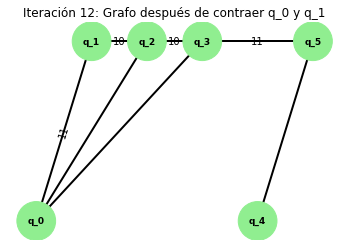

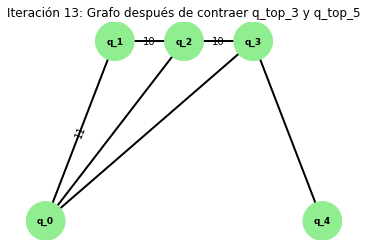

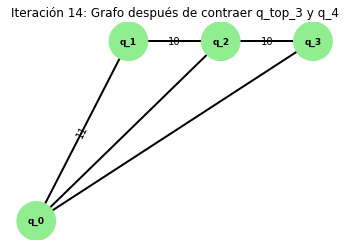

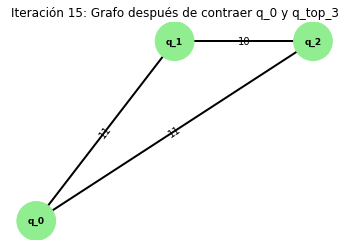

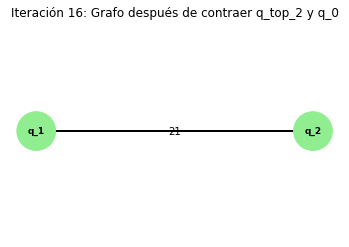

El corte minimo pasando por los quitbs [2, 1] es: 20


In [314]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit

def circuit_to_graph(qc):
    n_qubits = qc.num_qubits

    # Convertir a grafo
    G = nx.Graph()

    # Agregar nodos para cada qubit con etiquetas
    qubit_top_nodes = []
    for qubit in range(n_qubits):
        qubit_top_node = f'q_top_{qubit}'
        G.add_node(f'q_{qubit}', label=f'q_{qubit}')
        G.add_node(qubit_top_node, label=f'q_{qubit}')
        qubit_top_nodes.append(qubit)  # Guardar solo el número del qubit

    # Agregar nodos y aristas para las compuertas CNOT con identificadores únicos
    cnot_counter = 0
    previous_cnot_nodes = {}
    for gate, qubits, clbits in qc.data:
        if gate.name == 'cx':  # 'cx' es el nombre de la puerta CNOT en Qiskit
            qubit_indices = [qc.qubits.index(qubit) for qubit in qubits]
            cnot_id = f'CNOT-{cnot_counter}'
            G.add_node(cnot_id, label=f'CNOT-{cnot_counter}', index=cnot_counter)
            
            for qubit_index in qubit_indices:
                if qubit_index in previous_cnot_nodes:
                    G.add_edge(cnot_id, previous_cnot_nodes[qubit_index])
                else:
                    G.add_edge(cnot_id, f'q_{qubit_index}')
                previous_cnot_nodes[qubit_index] = cnot_id
            
            cnot_counter += 1

    # Conectar los últimos nodos CNOT a los qubits superiores
    for qubit_index in range(n_qubits):
        if qubit_index in previous_cnot_nodes:
            G.add_edge(previous_cnot_nodes[qubit_index], f'q_top_{qubit_index}')

    # Conectar los qubits superiores entre sí
    for i in range(len(qubit_top_nodes) - 1):
        G.add_edge(f'q_top_{qubit_top_nodes[i]}', f'q_top_{qubit_top_nodes[i + 1]}')

    # Fijar la posición de los nodos
    pos = {}
    # Posiciones de los qubits en una fila en la parte inferior
    for i in range(n_qubits):
        pos[f'q_{i}'] = (i, 0)
        pos[f'q_top_{i}'] = (i, cnot_counter + 2)  # Posiciones de los qubits superiores

    # Posiciones de las compuertas CNOT en filas superiores
    cnot_counter = 0
    for gate, qubits, clbits in qc.data:
        if gate.name == 'cx':
            qubit_indices = [qc.qubits.index(qubit) for qubit in qubits]
            cnot_id = f'CNOT-{cnot_counter}'
            pos[cnot_id] = (sum(qubit_indices) / len(qubit_indices), cnot_counter + 1)
            cnot_counter += 1

    return G, pos, qubit_top_nodes

# Ejemplo de uso
qc = QuantumCircuit(6)
qc.h(0)
qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(2, 1)
qc.cx(4, 5)
qc.cx(4, 5)

G, pos, qubit_top_nodes = circuit_to_graph(qc)

# Dibujar el grafo
plt.figure(figsize=(12, 12))
node_colors = ['skyblue' if 'CNOT' in node else 'lightgreen' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_color=node_colors, edge_color="black", node_size=1500, font_size=9, font_weight="bold", width=2)
plt.title("Grafo Representando el Circuito Cuántico")

# Mostrar el circuito cuántico y el grafo
display(qc.draw(output='mpl'))
plt.show()

# Ejecutamos el algoritmo de Karger varias veces para aumentar la precisión
trials = 1
min_cut = float('inf')
    
for _ in range(trials):
    cut = karger_algorithm.karger_min_cut_weighted(G, False)
    min_cut = min(min_cut, cut)
    
print("El corte mínimo encontrado por el algoritmo de Karger es:", min_cut)

# Excluir nodos 2 y 3
exclude_nodes = [2, 1]

min_cut = float('inf')
    
for _ in range(trials):
    cut = karger_min_cut_circuit(G, pos, True, qubit_top_nodes, exclude_nodes)
    min_cut = min(min_cut, cut)
    
print(f"El corte minimo pasando por los quitbs {exclude_nodes} es: {min_cut}")